# Introduction to Deep Learning using PyTorch
In this notebook I'm trying to work on real life application to learn PyTorch as well as Deep Learning. I'll be building a multi-layer neural network to identify text in an image. For this project I'm using MNIST dataset which consists of greyscale handwritten digits. Each image is a 28x28 pixels. the goal is to build a neural network that can take one of these images and predict the digit in the image.

In [21]:
#import important libraries
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

### Download and load the data

First up, we need to get our dataset. This is provided through the torchvision package. The code below will download the MNIST dataset, then create training and test datasets for us.

In [15]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

#Download and load the training data
trainset = datasets.MNIST('~/data/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


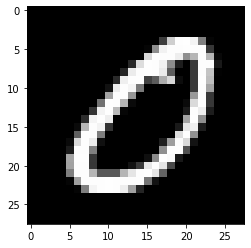

In [16]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

Now we flatten the batch of images images and then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. We are using ReLU activation for the hidden layer.

Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to.

### Losses and Activation
Given this is a classification problem, we'll be using the softmax function to predict the class probabilities. With a softmax output, we use a cross-entropy as the loss (**_nn.CrossEntropyLoss_**). To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels. However, one important point to note is that you can write cross-entropy loss separately using **_nn.LogSoftmax_** and **_nn.NLLLoss_** (Negative Log Likelihood Loss). _nn.CrossEntropyLoss_ combines these 2 in one single class.

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, **nn.Sequential**

### Autograd
Now since we've calculated the loss, how do we use it to perform backpropagation? Torch provides a module, **_autograd_**, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.

The gradients are computed with respect to some variable z with z.backward(). This does a backward pass through the operations that created z.

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor.

Thus to calculate gradients with respect to loss we calculate the loss and call loss.backward(), the gradients for the parameters are calculated.

### Training the network
There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's optim package. For example we can use stochastic gradient descent with optim.SGD. You can see how to define an optimizer below.

**imp:** When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches. Use _optimizer.zero_grad()_ (we've performed this operation above)

## Code:

In [17]:
# Build a feed forward network
model = nn.Sequential(nn.Linear(784, 128),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax(dim=1)) #dimension along which to calculate LogSoftmax.

# Define the loss
criterion = nn.NLLLoss()
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.0620953637971553
Training loss: 0.38070695081562883
Training loss: 0.32138995881051396
Training loss: 0.28964267891130724
Training loss: 0.26366026930288594


With the network trained, we can check out it's predictions.

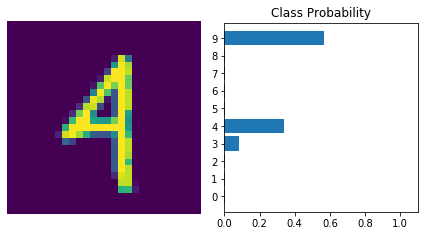

In [27]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

ps = ps.data.numpy().squeeze()

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()